# Compare - Shanghai Composite Index

1. PAPER: [Financial Time Series Forecasting with the Deep Learning Ensemble Model](https://www.mdpi.com/2227-7390/11/4/1054) by He K., et al. 2023
2. NOTE (of stock data):
    1. **Raw Data** is mostly non-stationary.
    2. **Returns Data** is stationary and also called differenced.

In [1]:
import os
import sys
# Get the current working directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../tslearn/'))

from collections import namedtuple
from data_loader import build_stock_uts, build_downloaded_stock_uts
from time_series import TimeSeriesFactory
from data_plotter import InterpolatePlotter
from ts_models_no_retrain import AR_Model, MA_Model, ARMA_Model, ARIMA_Model, EvaluationMetric

## Stock Data: Analysis

1. Load Raw Data
2. Plot Raw Data
3. Get Descriptive Statistics (ie: mean, median, range, etc) of Raw Data
4. Check Stationarity of Raw Data
5. Plot Autocorrelation and Partial Autocorrelation of Raw Data
6. Get Returns Data
7. Plot Returns Data
8. Get Descriptive Statistics (ie: mean, median, range, etc) of Returns Data
9. Check Stationarity of Returns Data
10. Plot Autocorrelation and Partial Autocorrelation of Returns Data

## Stock Data: Models

11. Split Returns Data
12. Initialize Models: `AR(p)` and `ARMA(p, q)`
13. Split Raw Data
14. Initialize Model: `ARMA(p, d, q)`

## Stock Data: Evaluation Metrics + Plots

15. Evaluation Metrics `MSE`, `RMSE`
16. Plot Actual Predictions vs Model Predictions

## Follow-up

- Notes on above

## Stock Data: Analysis

### Load Raw Data

In [2]:
# Only grab stocks whose data is available for the entire time period
start_date, end_date = "2010-01-04", "2020-02-07"
Stock = namedtuple("Stock", ["symbol", "name"])
stocks = [
    ("000001.SS", "Shanghai Composite Index")
]
independent_variable = "Close"
# # frequency = 
stocks = [Stock(*s) for s in stocks]
stocks = {s.symbol: build_stock_uts(s.symbol, s.name, independent_variable, start_date=start_date, end_date=end_date, frequency='1d') for s in stocks}

[*********************100%***********************]  1 of 1 completed


In [3]:
values_cols = list(stocks.keys())
stock_mvts = TimeSeriesFactory.create_time_series(
    time_col="date",
    time_values=stocks[values_cols[0]].data.index,
    values_cols=values_cols,
    values=[stock.get_series() for stock in stocks.values()]
)

Len [2447]
Len [2447]


In [4]:
stock_symbol = '000001.SS'
stock_of_interest = stocks[stock_symbol]
type(stock_of_interest), stock_of_interest

(time_series.UnivariateTimeSeries, UnivariateTimeSeries(Close))

In [5]:
stock_df = stock_of_interest.get_as_df()
stock_df

,Close
Date,
2010-01-04,3243.760010
2010-01-05,3282.178955
2010-01-06,3254.215088
2010-01-07,3192.775879
2010-01-08,3195.997070
...,...
2020-01-23,2976.528076
2020-02-03,2746.605957
2020-02-04,2783.288086


### Plot Raw Data

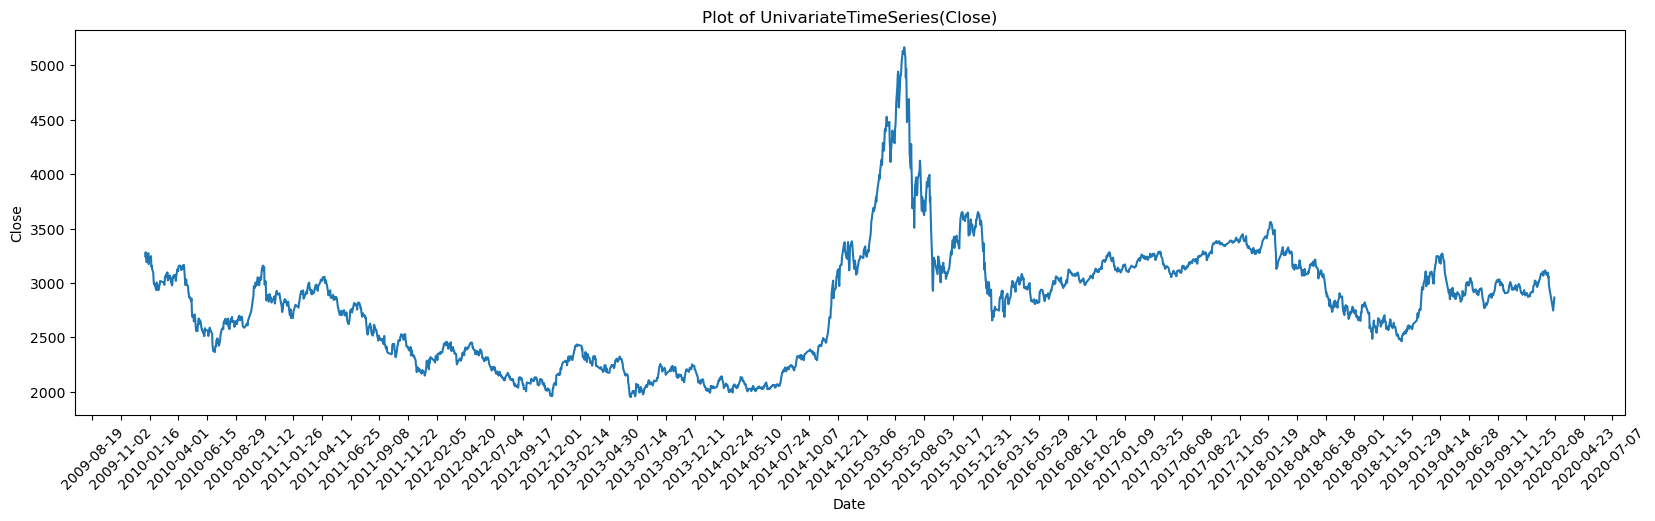

In [6]:
stock_of_interest.plot(tick_skip=75)

### Get Descriptive Statistics of Raw Data

In [7]:
stock_of_interest.get_statistics()

,Close
count,2447.000000
mean,2801.355809
std,529.298163
min,1950.011963
25%,2346.348389
50%,2859.758057
75%,3128.273560
max,5166.350098


In [8]:
stock_of_interest.range_skewness_kurtosis()

{'Range': Close    3216.338135
 dtype: float64,
 'Skewness': Close    0.748993
 dtype: float64,
 'Kurtosis': Close    1.537912
 dtype: float64}

### Check Stationarity of Raw Data

- With financial data, we expect it to be non-stationary (as in there's a change in either or both the mean of the variance between two distant points).

In [9]:
stock_of_interest.stationarity_test(stock_df)

ADF Statistic: -2.226796
p-value: 0.196664 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


### Plot Autocorrelation and Partial Autocorrelation of Raw Data

- Not required for `AR` or `ARMA` models as both models assumes stationary and the TS is non-stationary.

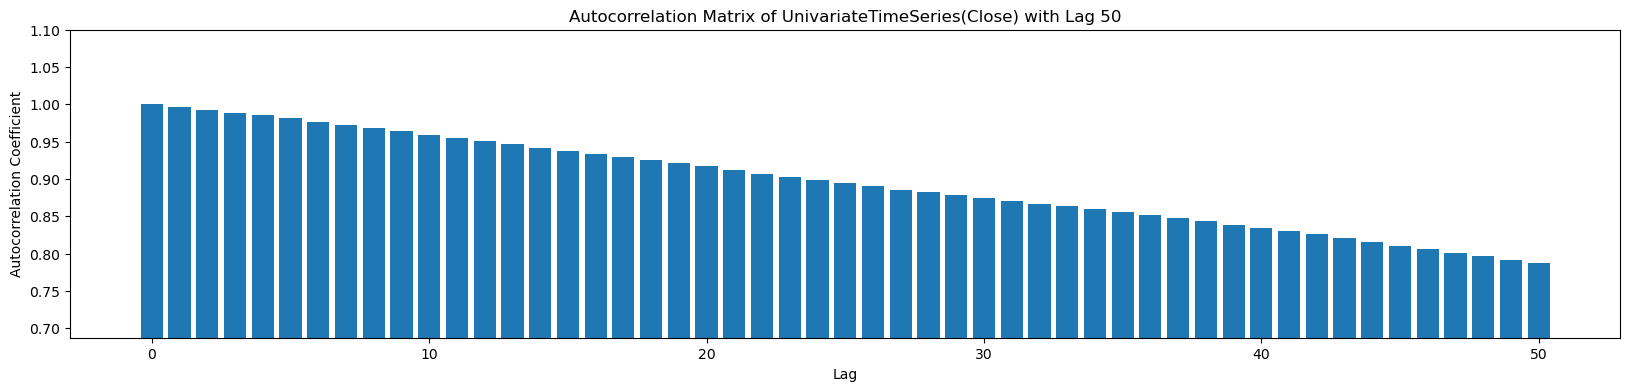

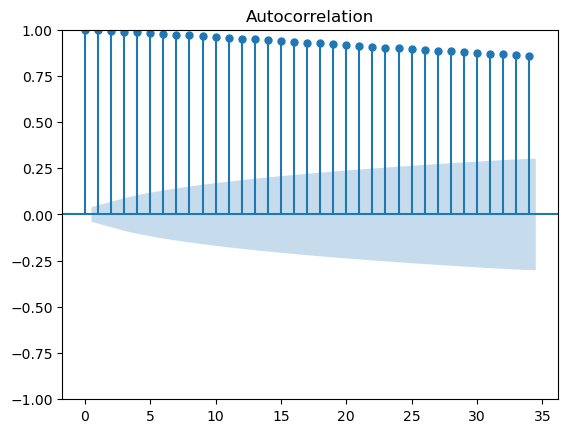

In [10]:
stock_of_interest.plot_autocorrelation(50)

- What is the above telling us?
    - Both plots are the same, just showing differently. 
    - Both plots confirm that the TS is non-stationary as in the current value depends on the previous value. We don't want this with traditional TS models like `AR`, `ARMA`.

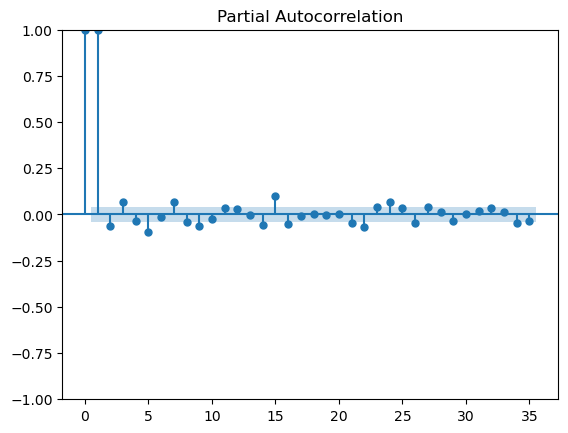

In [11]:
stock_of_interest.plot_partial_autocorrelation(35)

- What is the above telling us?
    - TS is non-stationary. Although data isn't as dependent (like the ACorr plot), the 1st is dependent upon the 0th. 

### Get Returns Data

- This should provide us with stationary data that we can pass to both `AR` and `ARMA` models.

In [12]:
len(stock_of_interest.get_series()), stock_of_interest.get_series()

(2447,
 array([3243.76000977, 3282.17895508, 3254.21508789, ..., 2783.28808594,
        2818.08789062, 2866.51000977]))

In [13]:
stock_returns = stock_of_interest.data_augment_for_returns()
stock_returns

UnivariateTimeSeries(Returns)

### Plot Returns

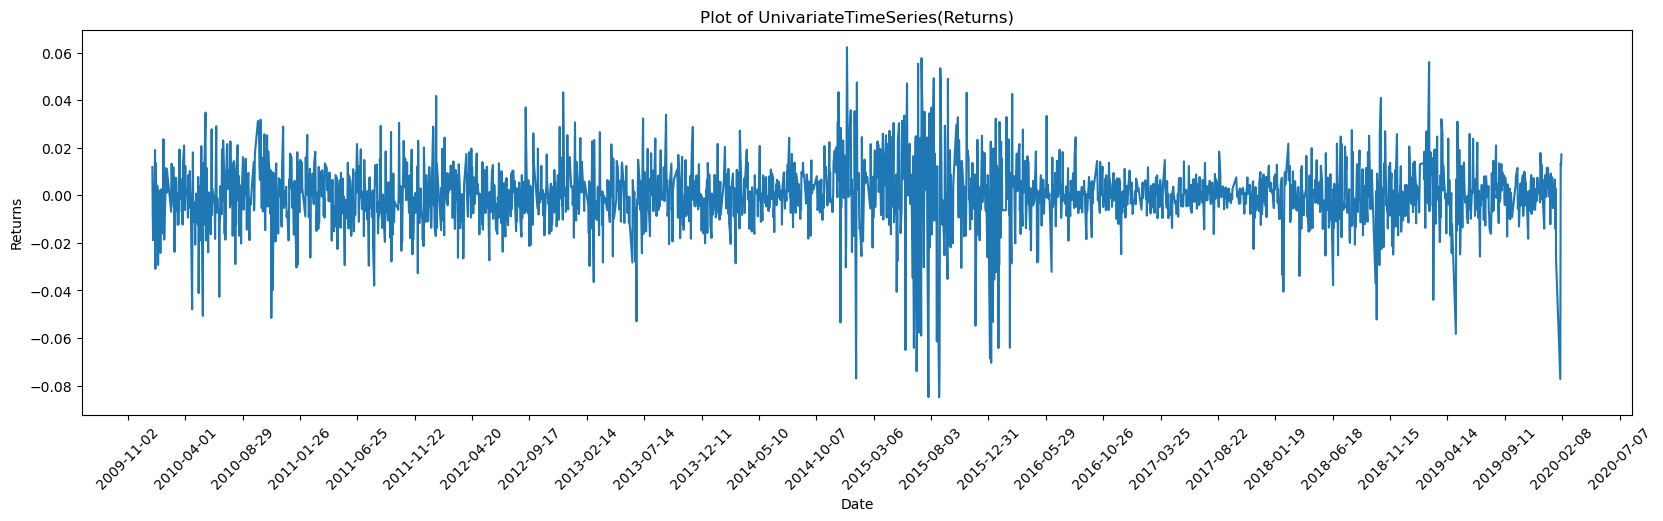

In [14]:
stock_returns.plot(tick_skip=150)

- Returns seem to have constant mean and constant variance although there are a few wide spread mean values between ~2014-10-07 to 2016-05-29 and ~2017-08-22 to 2019-04-14.

In [15]:
stock_returns_df = stock_returns.get_as_df()
stock_returns_df

,Returns
Date,
2010-01-05,0.011844
2010-01-06,-0.008520
2010-01-07,-0.018880
2010-01-08,0.001009
2010-01-11,0.005242
...,...
2020-01-23,-0.027518
2020-02-03,-0.077245
2020-02-04,0.013355


### Get Descriptive Statistics of Returns Data

In [16]:
stock_returns.get_statistics()

,Returns
count,2446.000000
mean,0.000043
std,0.013641
min,-0.084909
25%,-0.005829
50%,0.000502
75%,0.006362
max,0.062260


In [17]:
stock_returns.range_skewness_kurtosis()

{'Range': Returns    0.147169
 dtype: float64,
 'Skewness': Returns   -0.79317
 dtype: float64,
 'Kurtosis': Returns    5.834021
 dtype: float64}

### Check Stationarity of Returns Data

- Data is now stationary. Confirm with independence test which is only conducted on returns and has a null-hypothesis of data being independent (or not dependent).

In [18]:
stock_returns.stationarity_test(stock_returns_df)

ADF Statistic: -9.604483
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [19]:
stock_returns.independence_test(stock_returns_df)

BDS Statistic: 8.084943
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the differenced TS is independent and i.i.d.


### Plot Autocorrelation and Partial Autocorrelation of Returns Data

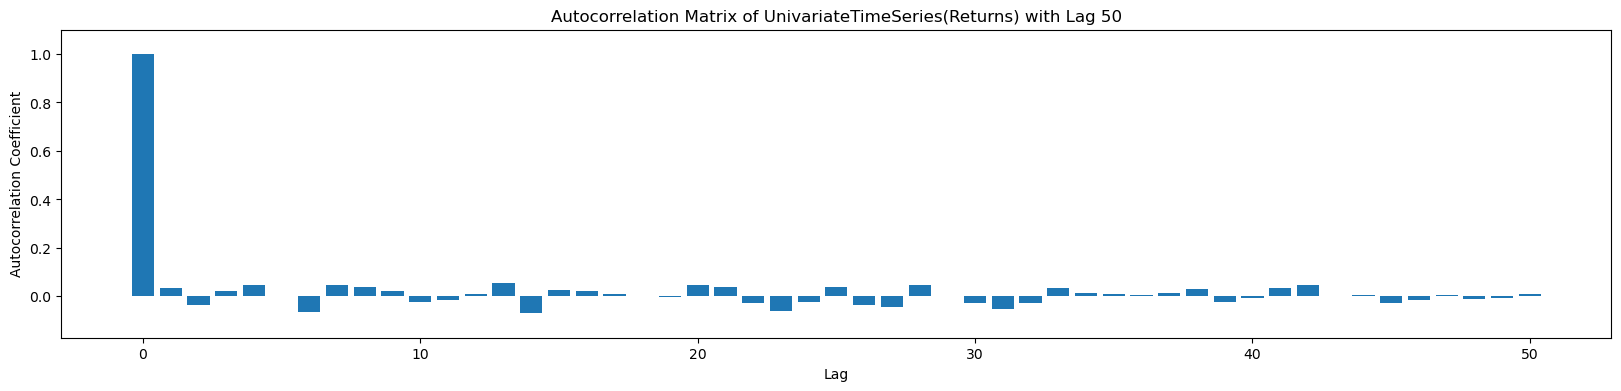

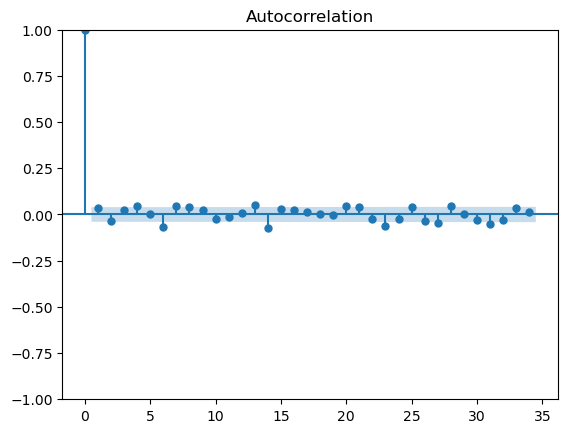

In [20]:
stock_returns.plot_autocorrelation(50)

- What is the above telling us?
    - Both plots are the same, just showing differently. 
    - Both plots confirm that the TS is stationary as in the current value doesn't depend on the previous value. This is what we want for `MA(q)`.
    - Lag exponentially decays at 1, thus use lag 1 for `MA(q)` as they have in the PAPER.


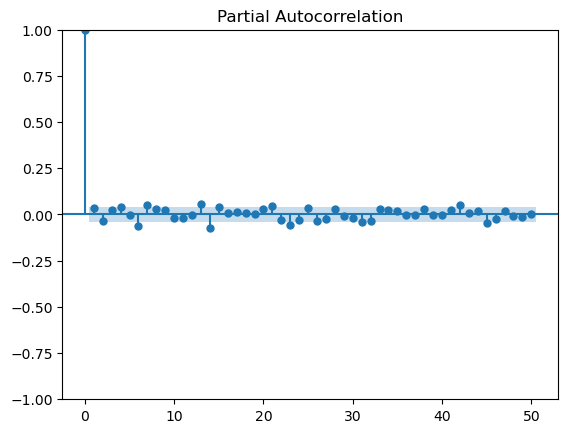

In [21]:
stock_returns.plot_partial_autocorrelation(50)

- What is the above telling us?
    - TS is stationary. The 1st is not dependent upon the 0th. This is what we want for `AR(p)`.
    - Lag exponentially decays at 1, thus use lag 1 for `AR(p)` as they have in the PAPER.

## Stock Data: Models

### Split Differenced Data for `AR(p)`, `MA(q)`, `ARMA(p, q)` Models

- Make 5-day forecasts

In [22]:
stock_returns.get_as_df()

,Returns
Date,
2010-01-05,0.011844
2010-01-06,-0.008520
2010-01-07,-0.018880
2010-01-08,0.001009
2010-01-11,0.005242
...,...
2020-01-23,-0.027518
2020-02-03,-0.077245
2020-02-04,0.013355


In [23]:
# interpolation_step = 5
# interpolation_step = 120
N = len(stock_returns.get_series())
interpolation_step = N - int(N * .8)
diff_train_length = N - interpolation_step

print(f"IS: {interpolation_step}\nTrain {diff_train_length}")

IS: 490
Train 1956


In [24]:
# interpolation_step = 1956
# # interpolation_step = 60
# N = len(stock_returns.get_series())
# diff_train_length = N - interpolation_step
# diff_train_length

In [25]:
diff_train_uts, diff_test_uts = stock_returns.get_slice(1, diff_train_length, both_train_test=True)
diff_train_uts, diff_test_uts

1 1956


(UnivariateTimeSeries(UnivariateTimeSeries(Returns)[1:1956]),
 UnivariateTimeSeries(UnivariateTimeSeries(Returns)[1956:2446]))

In [26]:
diff_train_df = diff_train_uts.get_as_df()
diff_train_df

,UnivariateTimeSeries(Returns)[1:1956]
Date,
2010-01-06,-0.008520
2010-01-07,-0.018880
2010-01-08,0.001009
2010-01-11,0.005242
2010-01-12,0.019054
...,...
2018-01-16,0.007655
2018-01-17,0.002350
2018-01-18,0.008733


In [27]:
diff_train_values = diff_train_uts.get_series()
diff_train_values

array([-0.00851991, -0.01887989,  0.0010089 , ...,  0.0087332 ,
        0.00377296,  0.00387   ])

- Make 5-day forecasts, hence why test data is only 5 values.

In [28]:
diff_test_df = diff_test_uts.get_as_df()
diff_test_df

,UnivariateTimeSeries(Returns)[1956:2446]
Date,
2018-01-23,0.012893
2018-01-24,0.003654
2018-01-25,-0.003135
2018-01-26,0.002768
2018-01-29,-0.009873
...,...
2020-01-23,-0.027518
2020-02-03,-0.077245
2020-02-04,0.013355


In [29]:
diff_test_values = diff_test_uts.get_series()
len(diff_test_values)

490

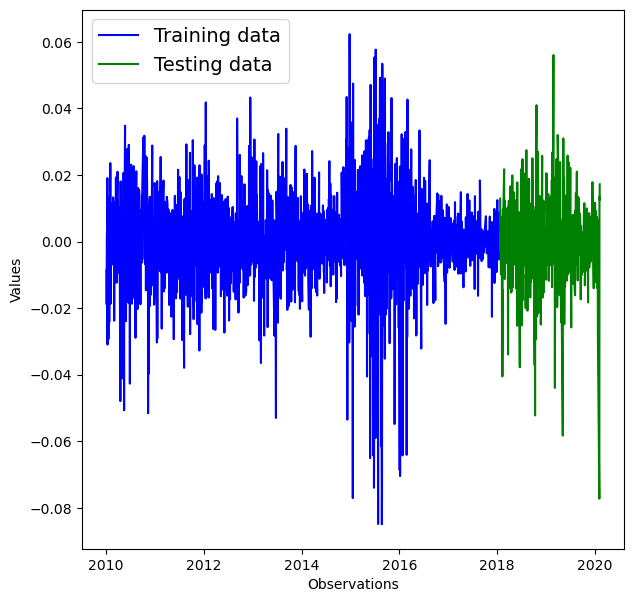

In [30]:
scatter_type = False
data_prediction_plots = InterpolatePlotter()
data_prediction_plots.plot_ts_training_and_testing_data(diff_train_df, diff_test_df, scatter_type)

#### Initialize Model: `AR(p)`

- Pass `diff_test_values` series instead of `diff_train_df` to drop index of the returned prediction

In [31]:
lag_p = 1 # AR

In [32]:
no_retrain_name = ' - no retrain'
no_retrain_bool = False

ar_no_retrain_model_class = AR_Model(no_retrain_name, lag_p)
ar_no_retrain_model_class.train(diff_train_values)
ar_no_retrain_model_class.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                 1955
Model:                     AutoReg(1)   Log Likelihood                5583.819
Method:               Conditional MLE   S.D. of innovations              0.014
Date:                Fri, 02 Aug 2024   AIC                         -11161.639
Time:                        21:31:17   BIC                         -11144.906
Sample:                             1   HQIC                        -11155.488
                                 1955                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.413      0.680      -0.000       0.001
y.L1           0.0401      0.023      1.775      0.076      -0.004       0.084
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           24.9295           +0.0000j           24.9295            0.0000
-----------------------------------------------------------------------------
"""

In [33]:
# retrain false
ar_predictions_no_retrain = ar_no_retrain_model_class.make_predictions(diff_train_values, diff_test_values)
ar_predictions_no_retrain
all_predictions_df = ar_no_retrain_model_class.model_predictions_to_df(diff_test_df, ar_predictions_no_retrain)
all_predictions_df

,UnivariateTimeSeries(Returns)[1956:2446],AR Model - no retrain
Date,,
2018-01-23,0.012893,0.000285
2018-01-24,0.003654,0.000141
2018-01-25,-0.003135,0.000135
2018-01-26,0.002768,0.000135
2018-01-29,-0.009873,0.000135
...,...,...
2020-01-23,-0.027518,0.000135
2020-02-03,-0.077245,0.000135
2020-02-04,0.013355,0.000135


In [34]:
predictions_df = all_predictions_df.iloc[:, 1]
# predictions_df

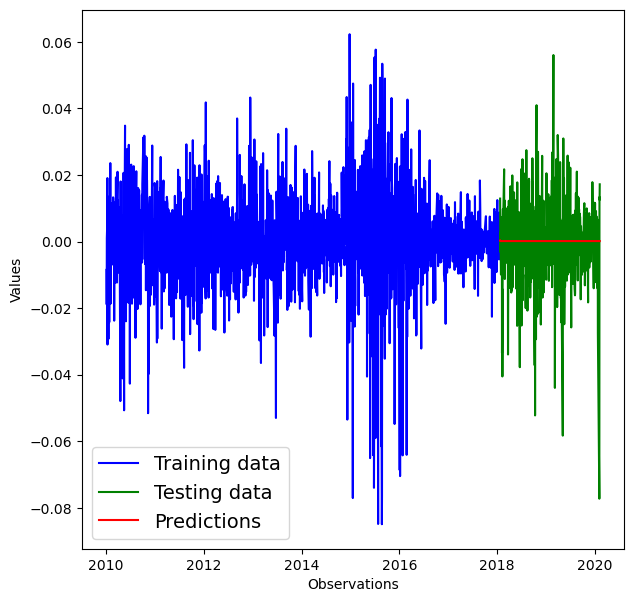

In [35]:
data_prediction_plots.plot_ts_training_and_testing_data(diff_train_df, diff_test_df, scatter_type, predictions_df)

In [36]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 1], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 1], per_element=False)

Test MSE: 0.000
Test RMSE: 0.013


#### Initialize Model: `MA(q)`

In [37]:
no_retrain_name

' - no retrain'

In [38]:
error_q = 1 # MA
ma_model_class = MA_Model(no_retrain_name, error_q=error_q)
ma_model_class.train(diff_train_df.values)
ma_model_class.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1955
Model:                 ARIMA(0, 0, 1)   Log Likelihood                5587.131
Date:                Fri, 02 Aug 2024   AIC                         -11168.262
Time:                        21:31:18   BIC                         -11151.528
Sample:                             0   HQIC                        -11162.111
                               - 1955                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      0.376      0.707      -0.001       0.001
ma.L1          0.0421      0.014      2.971      0.003       0.014       0.070
sigma2         0.0002   3.28e-06     58.754      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2926.59
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
ma_predictions_no_retrain = ma_model_class.make_predictions(diff_train_df, diff_test_df)
all_predictions_df = ma_model_class.model_predictions_to_df(diff_test_df, ma_predictions_no_retrain)
all_predictions_df

,UnivariateTimeSeries(Returns)[1956:2446],AR Model - no retrain,MA Model - no retrain
Date,,,
2018-01-23,0.012893,0.000285,0.000280
2018-01-24,0.003654,0.000141,0.000129
2018-01-25,-0.003135,0.000135,0.000129
2018-01-26,0.002768,0.000135,0.000129
2018-01-29,-0.009873,0.000135,0.000129
...,...,...,...
2020-01-23,-0.027518,0.000135,0.000129
2020-02-03,-0.077245,0.000135,0.000129
2020-02-04,0.013355,0.000135,0.000129


In [40]:
ma_predictions_df = all_predictions_df.iloc[:, 2]
ma_predictions_df

Date
2018-01-23    0.000280
2018-01-24    0.000129
2018-01-25    0.000129
2018-01-26    0.000129
2018-01-29    0.000129
                ...   
2020-01-23    0.000129
2020-02-03    0.000129
2020-02-04    0.000129
2020-02-05    0.000129
2020-02-06    0.000129
Name: MA Model - no retrain, Length: 490, dtype: float64

Test MSE: 0.000
Test RMSE: 0.013


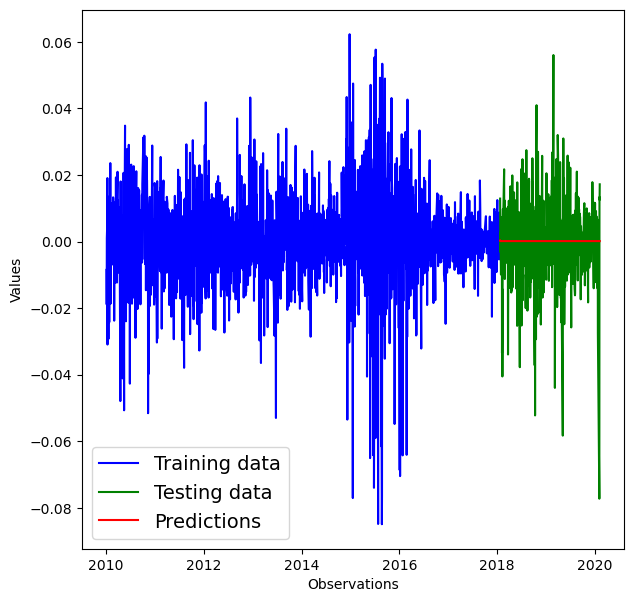

In [41]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 2], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 2], per_element=False)

data_prediction_plots.plot_ts_training_and_testing_data(diff_train_df, diff_test_df, scatter_type, ma_predictions_df)

#### Initialize Model: `ARMA(p, q)`

In [42]:
arma_model_class = ARMA_Model(no_retrain_name, lag_p, error_q)
arma_model_class.train(diff_train_df.values)
arma_model_class.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1955
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5587.615
Date:                Fri, 02 Aug 2024   AIC                         -11169.231
Time:                        21:31:18   BIC                         -11152.497
Sample:                             0   HQIC                        -11163.079
                               - 1955                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6224      0.151     -4.113      0.000      -0.919      -0.326
ma.L1          0.6647      0.144      4.608      0.000       0.382       0.947
sigma2         0.0002   3.18e-06     60.670      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              2902.29
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.69   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

NOTE: Should Dep. Variable be t as t depends on t - 1?

In [43]:
# retrain false
arma_predictions_no_retrain = arma_model_class.make_predictions(diff_train_df, diff_test_df)
all_predictions_df = arma_model_class.model_predictions_to_df(diff_test_df, arma_predictions_no_retrain)
all_predictions_df

,UnivariateTimeSeries(Returns)[1956:2446],AR Model - no retrain,MA Model - no retrain,ARMA Model - no retrain
Date,,,,
2018-01-23,0.012893,0.000285,0.000280,2.930955e-04
2018-01-24,0.003654,0.000141,0.000129,-1.824365e-04
2018-01-25,-0.003135,0.000135,0.000129,1.135571e-04
2018-01-26,0.002768,0.000135,0.000129,-7.068331e-05
2018-01-29,-0.009873,0.000135,0.000129,4.399663e-05
...,...,...,...,...
2020-01-23,-0.027518,0.000135,0.000129,-4.043454e-104
2020-02-03,-0.077245,0.000135,0.000129,2.516837e-104
2020-02-04,0.013355,0.000135,0.000129,-1.566598e-104


In [44]:
arma_predictions_df = all_predictions_df.iloc[:, 3]
arma_predictions_df

Date
2018-01-23     2.930955e-04
2018-01-24    -1.824365e-04
2018-01-25     1.135571e-04
2018-01-26    -7.068331e-05
2018-01-29     4.399663e-05
                  ...      
2020-01-23   -4.043454e-104
2020-02-03    2.516837e-104
2020-02-04   -1.566598e-104
2020-02-05    9.751247e-105
2020-02-06   -6.069637e-105
Name: ARMA Model - no retrain, Length: 490, dtype: float64

Test MSE: 0.000
Test RMSE: 0.013


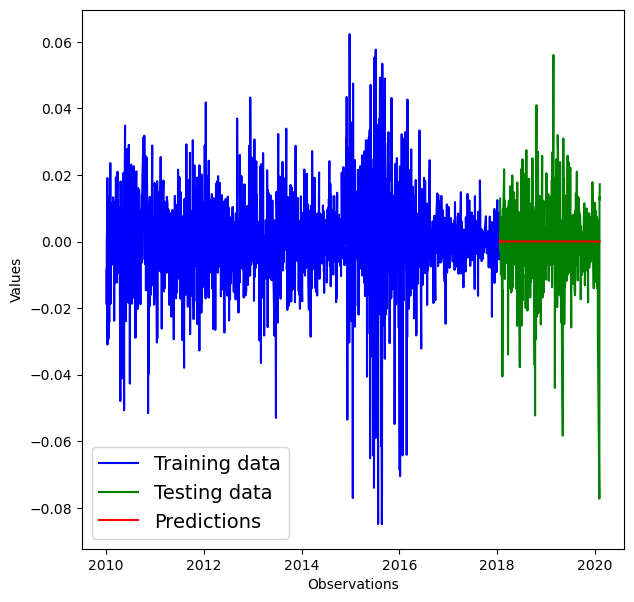

In [45]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 3], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 3], per_element=False)

data_prediction_plots.plot_ts_training_and_testing_data(diff_train_df, diff_test_df, scatter_type, arma_predictions_df)

### Split Raw Data for `ARIMA(p, d, q)` Model

- Make 5-day forecasts

In [46]:
# interpolation_step = 5
# interpolation_step = 60
# N = len(stock_of_interest.get_series())
# train_length = N - interpolation_step
# train_length

N = len(stock_of_interest.get_series())
interpolation_step = N - int(N * .8)
train_length = N - interpolation_step

print(f"IS: {interpolation_step}\nTrain {diff_train_length}")

IS: 490
Train 1956


In [47]:
train_uts, test_uts = stock_of_interest.get_slice(start=1, end=train_length, both_train_test=True)
train_uts, test_uts

1 1957


(UnivariateTimeSeries(UnivariateTimeSeries(Close)[1:1957]),
 UnivariateTimeSeries(UnivariateTimeSeries(Close)[1957:2447]))

(<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>)

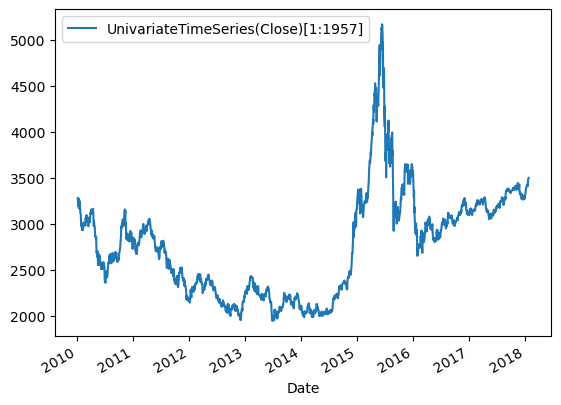

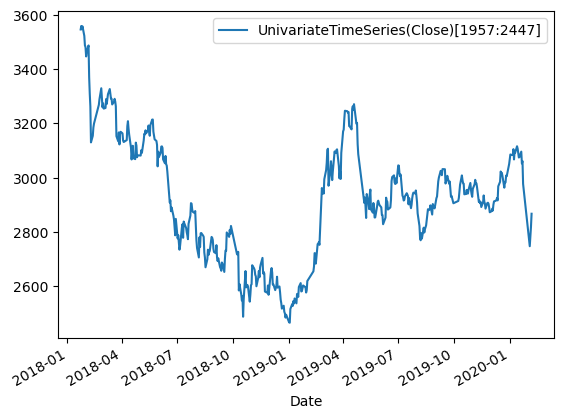

In [48]:
train_df = train_uts.get_as_df()
test_df = test_uts.get_as_df()
train_df.plot(), test_df.plot()

In [49]:
train_values = train_uts.get_series()
test_values = test_uts.get_series()
len(train_values), len(test_values)

(1956, 490)

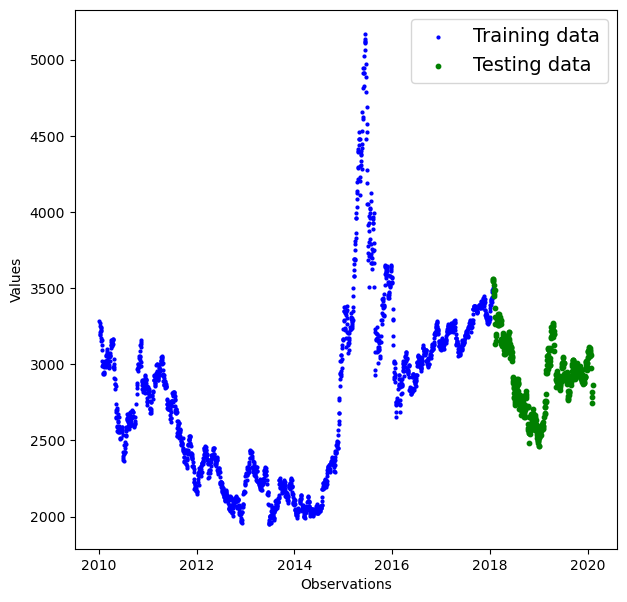

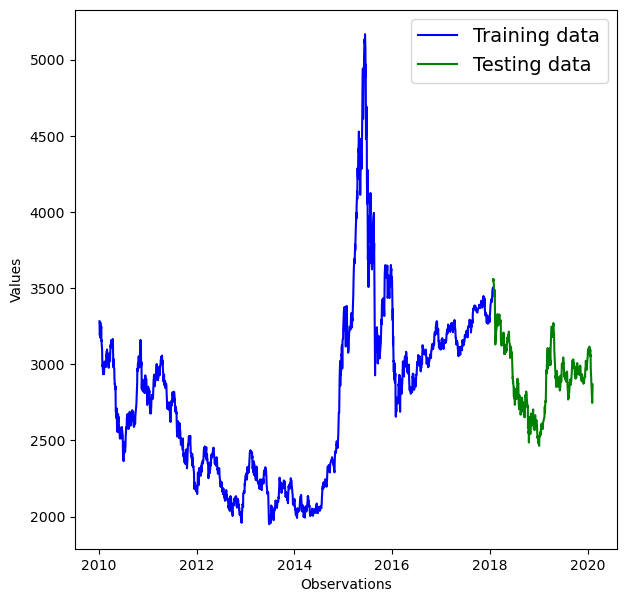

In [50]:
arima_plotter = InterpolatePlotter()
arima_plotter.plot_ts_training_and_testing_data(train_df, test_df, True)
arima_plotter.plot_ts_training_and_testing_data(train_df, test_df, False)

#### Initialize Models: `ARIMA(p, d, q)`

In [51]:
diff_d = 1

arima_model_class = ARIMA_Model(no_retrain_name, lag_p, error_q, diff_d)
trained_arima_model = arima_model_class.train(train_values)
# trained_arima_model.summary()

In [52]:
arima_predictions = arima_model_class.make_predictions(diff_train_values, diff_test_values)
all_raw_predictions_df = arima_model_class.model_predictions_to_df(test_df, arima_predictions)
all_raw_predictions_df

,UnivariateTimeSeries(Close)[1957:2447],ARIMA Model - no retrain
Date,,
2018-01-23,3546.504883,3487.715753
2018-01-24,3559.465088,3502.579955
2018-01-25,3548.306885,3502.142813
2018-01-26,3558.128906,3502.299718
2018-01-29,3523.000977,3502.243399
...,...,...
2020-01-23,2976.528076,3502.258275
2020-02-03,2746.605957,3502.258275
2020-02-04,2783.288086,3502.258275


In [53]:
arima_predictions_df = all_raw_predictions_df.iloc[:, 1]
len(arima_predictions_df), arima_predictions_df.head(3)

(490,
 Date
 2018-01-23    3487.715753
 2018-01-24    3502.579955
 2018-01-25    3502.142813
 Name: ARIMA Model - no retrain, dtype: float64)

Test MSE: 0.000
Test RMSE: 0.013


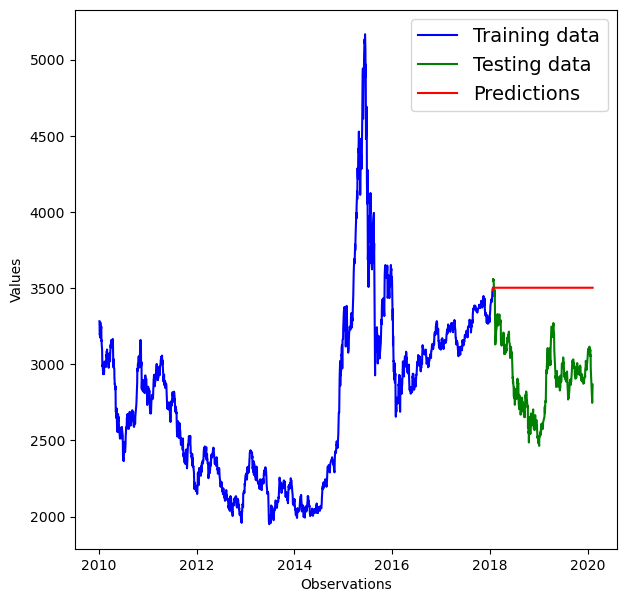

In [54]:
EvaluationMetric.eval_mse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 1], per_element=False)
EvaluationMetric.eval_rmse(all_predictions_df.iloc[:, 0], all_predictions_df.iloc[:, 1], per_element=False)

arima_plotter.plot_ts_training_and_testing_data(train_df, test_df, scatter_type=False, predictions_df=arima_predictions_df)

In [ ]:


# EvaluationMetric.eval_mse(test_df, arima_predictions_retrain, per_element=False)
# EvaluationMetric.eval_rmse(test_df, arima_predictions_retrain, per_element=False)

# arima_predictions_dict = {
#     'ARIMA No Retrain': arima_predictions_no_retrain,
# }
# scatter_plot = False
# prediction_plots = InterpolatePlotter(test_df, arima_predictions_dict)
# prediction_plots.plot_in_sample_predictions(scatter_plot)

# arima_predictions_dict = {
#     'ARIMA Retrain': arima_predictions_retrain,
# }
# scatter_plot = False
# prediction_plots = InterpolatePlotter(test_df, arima_predictions_dict)
# prediction_plots.plot_in_sample_predictions(scatter_plot)

## Stock Data: Evaluation Metrics + Plots

### Evaluation Metrics: MSE, RMSE

In [ ]:
# AR
EvaluationMetric.eval_mse(diff_test_df, ar_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, ar_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_mse(diff_test_df, ar_predictions_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, ar_predictions_retrain, per_element=False)

# ARMA
EvaluationMetric.eval_mse(diff_test_df, arma_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_mse(diff_test_df, arma_predictions_retrain, per_element=False)
EvaluationMetric.eval_rmse(diff_test_df, arma_predictions_retrain, per_element=False)

# ARIMA
EvaluationMetric.eval_mse(test_df, arima_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_rmse(test_df, arima_predictions_no_retrain, per_element=False)
EvaluationMetric.eval_mse(test_df, arima_predictions_retrain, per_element=False)
EvaluationMetric.eval_rmse(test_df, arima_predictions_retrain, per_element=False)

### Plots Actual Predictions vs Model Predictions
- Need to finish plots

In [ ]:
# predictions_dict = {
#     'AR No Retrain': ar_predictions_no_retrain,
#     'AR Retrain': ar_predictions_retrain,
#     'ARMA No Retrain': arma_predictions_no_retrain,
#     'ARMA Retrain': arma_predictions_retrain,
#     'ARIMA No Retrain': arima_predictions_no_retrain,
#     'ARIMA Retrain': arima_predictions_retrain
# }

In [ ]:
ar_predictions_dict = {
    'AR No Retrain': ar_predictions_no_retrain,
    'AR Retrain': ar_predictions_retrain,
    # 'ARMA Retrain': arma_predictions_retrain
}
scatter_plot = False
prediction_plots = InterpolatePlotter(diff_test_df, ar_predictions_dict)
prediction_plots.plot_in_sample_predictions(scatter_plot)

In [ ]:
# 'ARMA No Retrain': arma_predictions_no_retrain,
arma_predictions_dict = {

    'ARMA Retrain': arma_predictions_retrain,
}
prediction_plots = InterpolatePlotter(diff_test_df, arma_predictions_dict)
prediction_plots.plot_in_sample_predictions(scatter_plot)

arma_predictions_dict = {

    'ARIMA Retrain': arima_predictions_retrain
}
prediction_plots = InterpolatePlotter(diff_test_df, arma_predictions_dict)
prediction_plots.plot_in_sample_predictions(scatter_plot)

arma_predictions_dict = {

    'ARMA No Retrain': arma_predictions_no_retrain,
}
prediction_plots = InterpolatePlotter(diff_test_df, arma_predictions_dict)
prediction_plots.plot_in_sample_predictions(scatter_plot)

arima_predictions_dict = {

    'ARIMA No Retrain': arima_predictions_no_retrain,
}
prediction_plots = InterpolatePlotter(diff_test_df, arima_predictions_dict)
prediction_plots.plot_in_sample_predictions(scatter_plot)

In [ ]:
arima_predictions_no_retrain

## Follow-up